In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
scaler=StandardScaler()
retail=pd.read_csv("sales.csv")
products=pd.read_csv("products.csv")
products.drop("Unnamed: 0", axis=1, inplace=True)
retail.drop("Unnamed: 0", axis=1, inplace=True)
# Combine the date and time column to one datetime object
retail["invoice_date"]=pd.to_datetime(retail["invoice_date"])
retail["invoice_time"]=pd.to_timedelta(retail["invoice_time"], unit="H")
retail["invoice_date"]=retail["invoice_date"]+retail["invoice_time"]
retail.drop("invoice_time", axis=1, inplace=True)
# We have already cleaned our data in the EDA part

In [ ]:
# FUNCTIONS 

def removal(df,x):
    q1=df[x].quantile(0.05)
    q3=df[x].quantile(0.95)
    iqr=q3-q1
    return df[(df[x] >= q1 - 1.5*iqr) & (df[x] <= q3+1.5*iqr)]

In [ ]:
# Calculate total sales, No of orders and days since last order for each
# customers
rf=retail[["CustomerID", "total_sale"]]
rf=rf.groupby(by="CustomerID").sum()
# Order frequency
temp=retail.groupby(by="CustomerID")["InvoiceNo"].count()
temp=temp.reset_index()
temp.columns=["CustomerID", "freq"]
rf=pd.merge(rf, temp, on="CustomerID", how="inner")
# Days since last order
max_date=max(retail["invoice_date"])
retail["diff"]=max_date-retail["invoice_date"]
temp=retail.groupby("CustomerID")["diff"].min()
temp=temp.reset_index()
temp["diff"]=temp["diff"].dt.days
rf=pd.merge(rf, temp, on="CustomerID", how="inner")

In [ ]:
a=["total_sale", "freq", "diff"]
plt.subplots(figsize=(10,7))
sns.boxplot(data=rf[a], orient="v", whis=1.5, saturation=1, width=0.7)
plt.title("Outlier distribution")
plt.xlabel("Attributes")
plt.ylabel("Number of outlying values")

In [ ]:
# Removing the outliers using the IQR method
for i in rf:
    rf=removal(rf,i)

In [ ]:
rf

In [ ]:
rf_scaled=scaler.fit_transform(rf)
rf_scaled=pd.DataFrame(rf_scaled, columns=["CustomerID", "total_sale",
                                            "freq", "diff"])
rf_scaled

In [ ]:
kmeans=KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rf_scaled)
kmeans.labels_

In [ ]:
# Calculate the optimal number of clusters using the Elbow curve
temp=[]
a=[2, 3, 4, 5, 6, 7, 8, 9]
for i in a:
    kmeans=KMeans(n_clusters=i, max_iter=50)
    kmeans.fit(rf_scaled)
    temp.append(kmeans.inertia_)
plt.subplots(figsize=(12,7))
plt.plot(temp)
plt.xlabel("Number of clusters")
plt.ylabel("Distortion score")
plt.axvline(x=3, color="black", linestyle="dashed")
print("For our model the optimal cluster number is 3.")

In [ ]:
# Calculate silhouette score for each number of clusters
for i in a:
    kmeans=KMeans(n_clusters=i, max_iter=50)
    kmeans.fit(rf_scaled)
    x=kmeans.labels_
    x=silhouette_score(rf_scaled, x)
    print("For {0} clusters the silhouette score is {1}".format(i, x))

In [ ]:
# We will  go with 3 clusters
kmeans=KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rf_scaled)
rf["cluster"]=kmeans.labels_

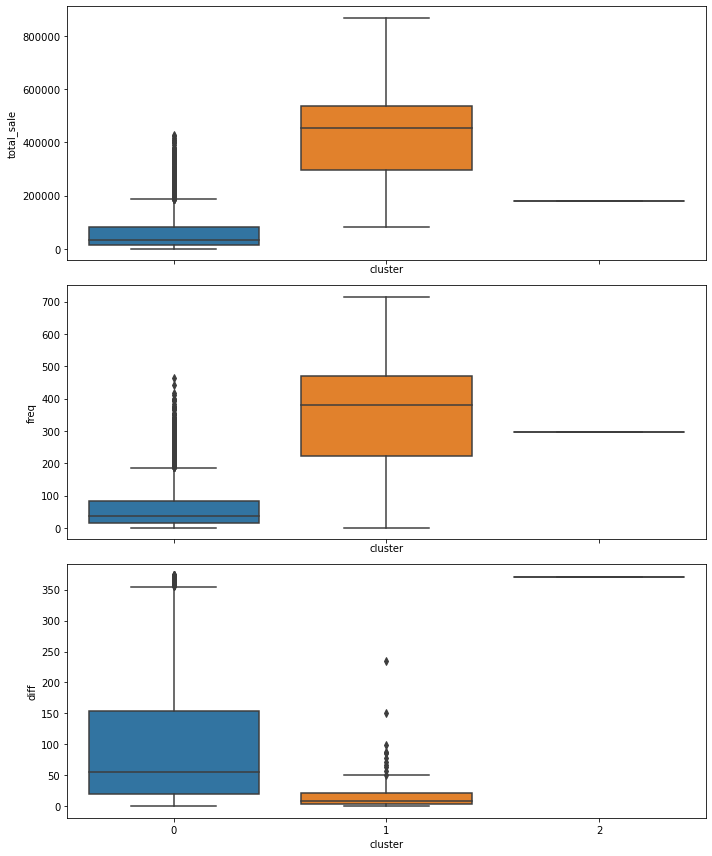

In [37]:
fig, ax=plt.subplots(3, 1, sharex=True, figsize=(10,12))
sns.boxplot(ax=ax[0], data= rf, x="cluster", y="total_sale")
sns.boxplot(ax=ax[1], data= rf, x="cluster", y="freq")
sns.boxplot(ax=ax[2], data= rf, x="cluster", y="diff")
plt.tight_layout()

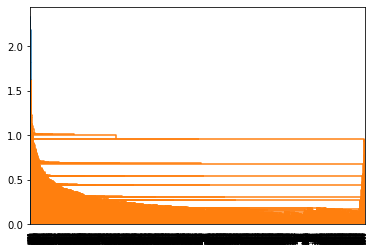

In [31]:
mergings=linkage(rf_scaled, method="single", metric="euclidean")
dendrogram(mergings)
plt.show()

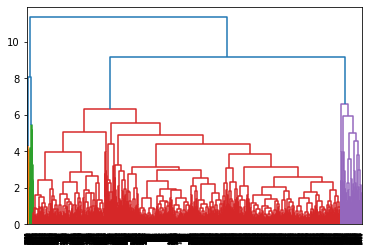

In [32]:
mergings=linkage(rf_scaled, method="complete", metric="euclidean")
dendrogram(mergings)
plt.show()

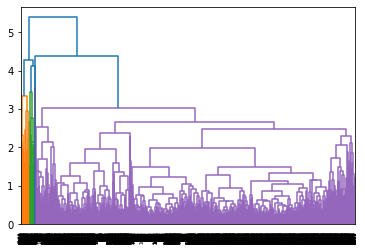

In [33]:
mergings=linkage(rf_scaled, method="average", metric="euclidean")
dendrogram(mergings)
plt.show()

In [ ]:
# We can cut those mergings trees into clusters themselves and assign 
# cluster ids this way.
a=cut_tree(mergings, n_clusters=3).reshape(-1,)
rf["cluster"]=a